In [33]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import os
import sys
import time
import skimage.measure
import subprocess
import random
import traceback
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
#from chamfer_distance import ChamferDistance
from neuralnet_pytorch.metrics import chamfer_loss
chamfer_dist = chamfer_loss
from sklearn.neighbors import KDTree

#from mayavi import mlab
import plyfile
from pyntcloud import PyntCloud
from plyfile import PlyData

import deep_sdf
import deep_sdf.workspace as ws
from reconstruct import reconstruct

from custom_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## F decalration

Model F(p) - distance of the point from the sphere

In [2]:
RADIUS = 0.25

def mod(x, y, z):
    return x ** 2 + y ** 2 + z ** 2

def compute_loss(x, y, z):
    return (RADIUS - mod(x, y, z)) ** 2

def grad_modulo(x, y, z):
    return 4 * abs(RADIUS - mod(x, y, z)) * (mod(x, y, z) ** (1/2))

def grad_x(x, y, z):
    return 4*x*mod(x, y, z)
def grad_y(x, y, z):
    return 4*y*mod(x, y, z)
def grad_z(x, y, z):
    return 4*z*mod(x, y, z)

def deriv_sign(x, y, z):
    ret = 1
    if mod(x, y, z) > RADIUS:
        ret = -1
    return ret

### Load stuff

In [3]:
experiment_directory = "/cvlabdata2/home/artem/DeepSDF/examples/planes/"
checkpoint = "latest"

decoder = load_model(experiment_directory, checkpoint)
decoder.eval()

Decoder(
  (lin0): Linear(in_features=259, out_features=512, bias=True)
  (lin1): Linear(in_features=512, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=253, bias=True)
  (lin4): Linear(in_features=512, out_features=512, bias=True)
  (lin5): Linear(in_features=512, out_features=512, bias=True)
  (lin6): Linear(in_features=512, out_features=512, bias=True)
  (lin7): Linear(in_features=512, out_features=512, bias=True)
  (lin8): Linear(in_features=512, out_features=1, bias=True)
  (relu): ReLU()
  (th): Tanh()
)

In [4]:
latent_vectors = ws.load_latent_vectors(experiment_directory, checkpoint)
latent_size = latent_vectors[0].size()[1]
print(f"{len(latent_vectors)} of latent vectors, each {latent_size} long")

1780 of latent vectors, each 256 long


## Get a point that has 0 SDF value

In [5]:
def get_sdf_predictions(decoder, latent, points):
    return deep_sdf.utils.decode_sdf(decoder, latent, points).squeeze(1).detach().cpu().numpy()

In [6]:
def get_points_on_surface(decoder, latent, points, num_iters=100, lr=0.02, decreased_by=2, adjust_lr_every=5):

    def adjust_learning_rate(
        initial_lr, optimizer, num_iterations, decreased_by, adjust_lr_every
    ):
        lr = initial_lr * ((1 / decreased_by) ** (num_iterations // adjust_lr_every))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
    
    decoder.eval()

    current_points = torch.cuda.FloatTensor(points.detach().cpu().numpy())
    current_points.requires_grad = True
    
    latent = torch.Tensor(latent.cpu().detach().numpy()).cuda()
    ref_sdf = torch.cuda.FloatTensor([[0]] * len(points))
    
    optimizer = torch.optim.Adam([current_points], lr=lr)
    loss_l1 = torch.nn.L1Loss()
    
    for i in range(num_iters):
        adjust_learning_rate(lr, optimizer, i, decreased_by, adjust_lr_every)
        
        sdf_value = deep_sdf.decode_sdf(decoder, latent, current_points)
        
        optimizer.zero_grad()
        loss = loss_l1(sdf_value, ref_sdf)
        loss.backward()
        optimizer.step()
        
    return current_points

In [7]:
# null_points = get_points_on_surface(decoder, initial_latent, [[0, 0, 1], [0, 0, 0], [1, 0, 0]])
# get_sdf_predictions(decoder, initial_latent, null_points)

## Full cycle

In [36]:
def eduardos__sphere_mult(points):
    return [[- grad_x(x, y, z) / dx\
             - grad_y(x, y, z) / dy\
             - grad_z(x, y, z) / dz]\
             for (x, y, z), (dx, dy, dz) in zip(points, points.grad)]

def method4_sphere_mult(points):
    return [[deriv_sign(x,y,z) *  grad_modulo(x,y,z)] for x, y, z in points]


def loss_sphere(points):
    loss = 0
    for x, y, z in points:
        loss += compute_loss(x, y, z)
    return loss.detach().cpu().numpy()


def method4_to_another_shape(points, ref_points):
    initial_dir = points.grad.clone()
    points.grad.data.zero_()

    #chamfer_dist = ChamferDistance()
    dist1, dist2 = chamfer_dist(points[None, :, :], ref_points[None, :, :])
    loss = (torch.mean(dist1) + torch.mean(dist2)) 
    loss.backward()
    
    
    #print('Initial: ', initial_dir)
    #print('Grad: ', points.grad)
#    modulo = [sum(pg ** 2) for pg in points.grad]
    #for p1, p2 in  zip(initial_dir, points.grad):
    #     print(p1, p2, p1.dot(p2))
#    sign = [1 if p1.dot(p2) < 0 else -1 for p1, p2 in zip(initial_dir, points.grad)]
    sign = [-p1.dot(p2) for p1, p2 in zip(initial_dir, points.grad)]
    #print('Modulo: ', [float(m.detach().cpu().numpy()) for m in modulo])
    #print('Sign:   ', sign)
    #print('Ans: ', [[s * m] for s, m in zip(sign, modulo)])
    #print()
    return [[s] for s in sign]
#    return [[s * m] for s, m in zip(sign, modulo)]

def chd_loss(points, ref_points):
    #chamfer_dist = ChamferDistance()
    dist1, dist2 = chamfer_dist(points[None, :, :], ref_points[None, :, :])
    loss = (torch.mean(dist1) + torch.mean(dist2))
    return loss

def optimize_shape(decoder, latent, ref_latent, initial_points=None, num_points=10, 
                   num_iters=100, point_iters=100, get_grad=grad_modulo, punch_lr_at_reindex_by=1,
                   get_sign=deriv_sign, loss=compute_loss, 
                   reindex_latent_each=50, reindex_num_iterations=500, reindex_num_samples=100,
                   lr=0.2, decreased_by=2, adjust_lr_every=10, 
                   multiplier_func=method4_sphere_mult, loss_func=loss_sphere, verbose=None, save_to_dir=None):

    def adjust_learning_rate(
        initial_lr, optimizer, num_iterations, decreased_by, adjust_lr_every
    ):
        lr = initial_lr * ((1 / decreased_by) ** (num_iterations // adjust_lr_every)) \
                        * ((punch_lr_at_reindex_by) ** (num_iterations // reindex_latent_each))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
            
        return lr
    
    if not os.path.exists(os.path.join(save_to_dir, 'meshes')):
        os.makedirs(os.path.join(save_to_dir, 'meshes'))
    
    try:
        decoder.eval()
        latent = torch.Tensor(latent.cpu().detach().numpy()).cuda()
        latent.requires_grad = True
        optimizer = torch.optim.Adam([latent], lr=lr)

        loss_plot = []
        latent_dist = []
        lr_plot = []

    #         if initial_points is not None:
    #             points = initial_points.clone()
    #         else:
    #             points = get_points_from_latent(decoder, latent, N=128, point_num=num_points)

        for i in tqdm(range(num_iters)):
            
            save_path = os.path.join(save_to_dir, 'meshes/' + str(i).zfill(5) + ".ply")
            
            if i > 0 and i == reindex_latent_each:
                new_latent = get_latent_from_mesh(decoder, latent_size=latent.size()[1], 
                                                  num_iterations=reindex_num_iterations, 
                                                  num_samples=reindex_num_samples)
                latent = torch.Tensor(new_latent.cpu().detach().numpy()).cuda()
                latent.requires_grad = True
                optimizer = torch.optim.Adam([latent], lr=lr)

            cur_rl = adjust_learning_rate(lr, optimizer, i, decreased_by, adjust_lr_every)

            points = get_points_from_latent(decoder, latent, N=128, point_num=num_points, save_path=save_path) # grid
            # points = get_points_on_surface(decoder, latent, points, num_iters=point_iters)  # optimization
            points.requires_grad = True

            sdf_value = deep_sdf.utils.decode_sdf(decoder, latent, points)
            sdf_value.backward(torch.ones([len(points), 1], dtype=torch.float32).cuda())
            multipliers = torch.cuda.FloatTensor(multiplier_func(points))

            optimizer.zero_grad()
            sdf_value = deep_sdf.utils.decode_sdf(decoder, latent, points)
            sdf_value.backward(multipliers)
            #print(multipliers)
            #print(latent.grad)
            optimizer.step()

            loss_value = loss_func(points)
            
            if save_to_dir is not None:
                plot_points_from_torch
                
            if verbose is not None and i % verbose == 0:
                print('Iter ', i, 'Loss: ', loss_value.detach().cpu().numpy(), ' LR: ', cur_rl)
                #plot_points_from_torch(points)

            loss_plot.append(loss_value.cpu().detach().numpy())
            latent_dist.append(torch.sum((latent - ref_latent) ** 2 ).cpu().detach().numpy() )
            lr_plot.append(cur_rl)
    except KeyboardInterrupt:
        print("Paused")
    finally:
        np.save(os.path.join(save_to_dir, "loss_plot.npy"), loss_plot)
        np.save(os.path.join(save_to_dir, "latent_dist.npy"), latent_dist)
        np.save(os.path.join(save_to_dir, "lr_plot.npy"), lr_plot)
        raise
        return latent, loss_plot, latent_dist

## Initial meshes 

13, 18

900

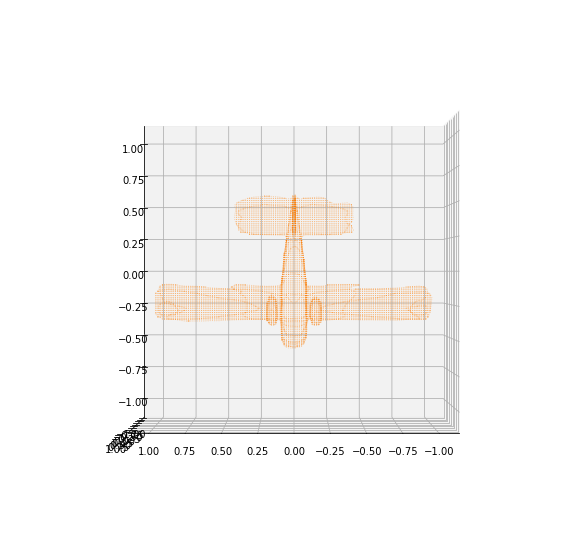

In [9]:
ref_latent = latent_vectors[13].clone()
plot_mesh_from_vector(decoder, ref_latent, N=128)

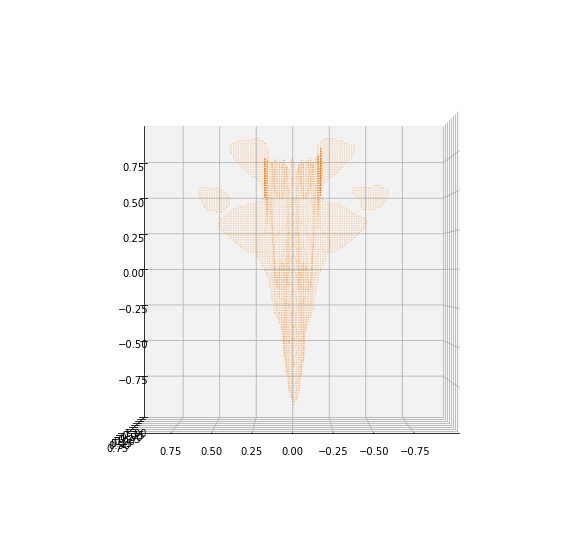

In [10]:
initial_latent = latent_vectors[18].clone()
plot_mesh_from_vector(decoder, initial_latent, N=128)

In [16]:
ref_points = get_points_from_latent(decoder, ref_latent, N=128)
initial_points = get_points_from_latent(decoder, initial_latent, N=128)

# chamfer_dist = ChamferDistance()
dist1, dist2 = chamfer_dist(initial_points[None, :, :], ref_points[None, :, :])
loss = (torch.mean(dist1)) + (torch.mean(dist2))

print('Initial distance: ', loss)

TypeError: iteration over a 0-d tensor

In [15]:
initial_points.size()

torch.Size([11173, 3])

In [13]:
# for i in range(0, len(ref_points)):
#     ref_points[i][0] += random.random() / 30
#     ref_points[i][1] += random.random() / 30
#     ref_points[i][2] += random.random() / 30

In [20]:
plot_points_from_torch(torch.cat((ref_points, initial_points), dim=0))

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [21]:
chd_loss(ref_points, initial_points)

TypeError: iteration over a 0-d tensor

## Num points = 1

In [22]:
num_points = 30000
initial_latent = latent_vectors[0].clone()
red_ref_points = subsample_from_torch_tensor(ref_points, num_points)
red_ini_points = subsample_from_torch_tensor(initial_points, num_points)

In [24]:
save_to_dir = '../Expirements/SavedTransforms/99-18_1'
if not os.path.exists(save_to_dir):
    os.makedirs(save_to_dir)

np.save(os.path.join(save_to_dir, "target_verts.npy"), ref_points.cpu())

opt_latent, loss_hist, latent_dist  =\
                optimize_shape(decoder, initial_latent, ref_latent, initial_points=None, reindex_latent_each=100,
                               num_points=None, num_iters=1000, adjust_lr_every=10, point_iters=2, decreased_by=1.2,
                               multiplier_func=lambda x: method4_to_another_shape(x, ref_points),
                               loss_func=lambda x: chd_loss(x, ref_points), lr=0.005, verbose=10, 
                               save_to_dir=save_to_dir)

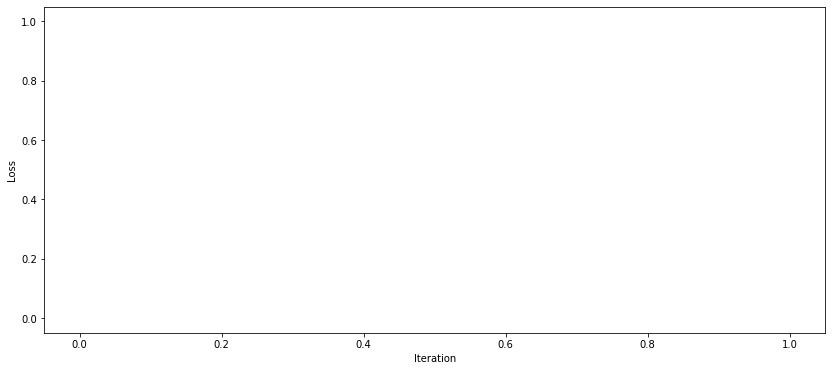

In [25]:
plt.figure(figsize=(14, 6))
#plt.yscale("log")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(loss_hist)
plt.show()

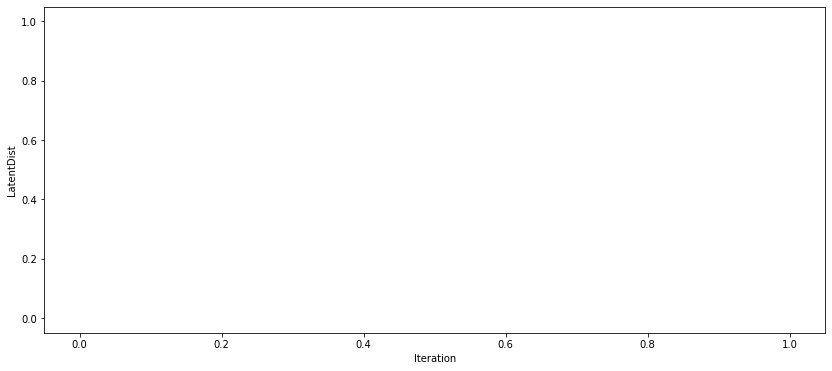

In [26]:
plt.figure(figsize=(14, 6))
#plt.yscale("log")
plt.xlabel('Iteration')
plt.ylabel('LatentDist')
plt.plot(latent_dist)
plt.show()

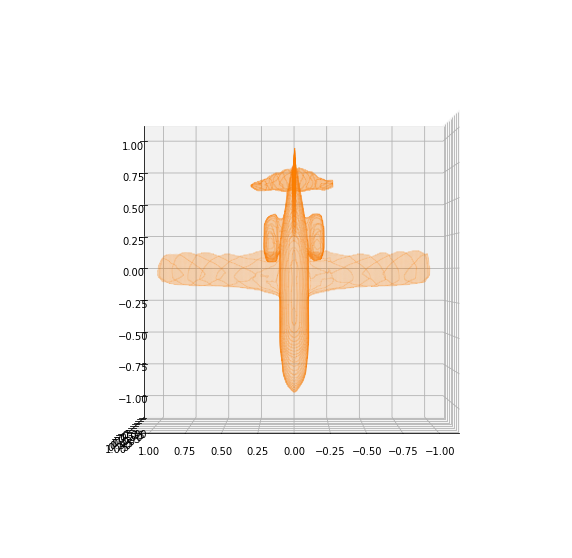

In [27]:
plot_mesh_from_vector(decoder, opt_latent, N=256)

In [28]:
torch.sum((opt_latent - ref_latent) ** 2)

tensor(1.8423, device='cuda:0', grad_fn=<SumBackward0>)

## A lot of automized experiments

In [34]:
def make_full_transformation(initial_latent, ref_latent, experiment_name, decoder, **kwargs):
    '''
    kwargs:
        num_iters=1000, 
        adjust_lr_every=10, 
        decreased_by=1.2,
        lr=0.005,
        
        reindex_latent_each=100,
        punch_lr_at_reindex_by=1,
        reindex_num_iterations=500, 
        reindex_num_samples=100,
        
        verbose=10,
    '''

    ref_points = get_points_from_latent(decoder, ref_latent, N=128)

    save_to_dir = os.path.join('../Expirements/SavedTransforms/' + experiment_name)
    if not os.path.exists(save_to_dir):
        os.makedirs(save_to_dir)

    np.save(os.path.join(save_to_dir, "target_verts.npy"), ref_points.cpu())

    opt_latent, loss_hist, latent_dist  =\
                    optimize_shape(decoder, initial_latent, ref_latent, initial_points=None,
                                   num_points=None, point_iters=2,
                                   multiplier_func=lambda x: method4_to_another_shape(x, ref_points),
                                   loss_func=lambda x: chd_loss(x, ref_points), 
                                   save_to_dir=save_to_dir, **kwargs)
    
    return opt_latent, loss_hist, latent_dist

In [38]:
!pwd

/cvlabdata2/home/artem/DeepSDF


In [37]:
opt_latent, loss_hist, latent_dist =\
make_full_transformation(latent_vectors[0].clone(), latent_vectors[99].clone(), "0-99_usual", decoder, 
                         num_iters=1000, 
                         adjust_lr_every=20, 
                         decreased_by=1.1,
                         lr=0.005,
                         verbose=10,
                         reindex_latent_each=10000,
                         punch_lr_at_reindex_by=1,
                         reindex_num_iterations=500, 
                         reindex_num_samples=100,)

  0%|          | 0/1000 [00:02<?, ?it/s]


TypeError: iteration over a 0-d tensor

In [ ]:
opt_latent, loss_hist, latent_dist =\
make_full_transformation(latent_vectors[0].clone(), latent_vectors[18].clone(), "0-18_usual", decoder, 
                         num_iters=1000, 
                         adjust_lr_every=10, 
                         decreased_by=1.1,
                         lr=0.005,
                         verbose=None,
                         reindex_latent_each=10000,
                         punch_lr_at_reindex_by=1,
                         reindex_num_iterations=500, 
                         reindex_num_samples=100,)

In [ ]:
opt_latent, loss_hist, latent_dist =\
make_full_transformation(latent_vectors[0].clone(), latent_vectors[13].clone(), "0-13_usual", decoder, 
                         num_iters=1000, 
                         adjust_lr_every=10, 
                         decreased_by=1.1,
                         lr=0.005,
                         verbose=None,
                         reindex_latent_each=10000,
                         punch_lr_at_reindex_by=1,
                         reindex_num_iterations=500, 
                         reindex_num_samples=100,)

In [ ]:
opt_latent, loss_hist, latent_dist =\
make_full_transformation(latent_vectors[0].clone(), latent_vectors[18].clone(), "0-18_reindex_weak", decoder, 
                         num_iters=1000, 
                         adjust_lr_every=10, 
                         decreased_by=1.2,
                         lr=0.005,
                         verbose=None,
                         reindex_latent_each=100,
                         punch_lr_at_reindex_by=1.2 ** 3,
                         reindex_num_iterations=500, 
                         reindex_num_samples=100,)

In [ ]:
opt_latent, loss_hist, latent_dist =\
make_full_transformation(latent_vectors[0].clone(), latent_vectors[13].clone(), "0-13_reindex_weak", decoder, 
                         num_iters=1000, 
                         adjust_lr_every=10, 
                         decreased_by=1.2,
                         lr=0.005,
                         verbose=None,
                         reindex_latent_each=100,
                         punch_lr_at_reindex_by=1.2 ** 3,
                         reindex_num_iterations=500, 
                         reindex_num_samples=100,)

In [ ]:
opt_latent, loss_hist, latent_dist =\
make_full_transformation(latent_vectors[0].clone(), latent_vectors[18].clone(), "0-18_reindex_strong", decoder, 
                         num_iters=1000, 
                         adjust_lr_every=10, 
                         decreased_by=1.2,
                         lr=0.005,
                         verbose=None,
                         reindex_latent_each=100,
                         punch_lr_at_reindex_by=1.2 ** 3,
                         reindex_num_iterations=500, 
                         reindex_num_samples=1000,)

In [ ]:
opt_latent, loss_hist, latent_dist =\
make_full_transformation(latent_vectors[0].clone(), latent_vectors[18].clone(), "0-18_super_weak", decoder, 
                         num_iters=1000, 
                         adjust_lr_every=10, 
                         decreased_by=1.2,
                         lr=0.005,
                         verbose=None,
                         reindex_latent_each=100,
                         punch_lr_at_reindex_by=1.2 ** 3,
                         reindex_num_iterations=10, 
                         reindex_num_samples=100,)

In [ ]:
opt_latent, loss_hist, latent_dist =\
make_full_transformation(latent_vectors[0].clone(), latent_vectors[13].clone(), "0-13_super_weak", decoder, 
                         num_iters=1000, 
                         adjust_lr_every=10, 
                         decreased_by=1.2,
                         lr=0.005,
                         verbose=None,
                         reindex_latent_each=100,
                         punch_lr_at_reindex_by=1.2 ** 3,
                         reindex_num_iterations=10, 
                         reindex_num_samples=100,)

In [ ]:
opt_latent, loss_hist, latent_dist =\
make_full_transformation(latent_vectors[0].clone(), latent_vectors[18].clone(), "0-18_reindex_weak_hp", decoder, 
                         num_iters=400,
                         adjust_lr_every=20,
                         decreased_by=1.1,
                         lr=0.005,
                         verbose=None,
                         reindex_latent_each=200,
                         punch_lr_at_reindex_by=1.1 ** 10,
                         reindex_num_iterations=500, 
                         reindex_num_samples=100,)

In [ ]:
opt_latent, loss_hist, latent_dist =\
make_full_transformation(latent_vectors[0].clone(), latent_vectors[13].clone(), "0-13_reindex_weak_hp", decoder, 
                         num_iters=400,
                         adjust_lr_every=20,
                         decreased_by=1.1,
                         lr=0.005,
                         verbose=None,
                         reindex_latent_each=200,
                         punch_lr_at_reindex_by=1.1 ** 10,
                         reindex_num_iterations=500, 
                         reindex_num_samples=100,)

In [ ]:
np.load('../Expirements/SavedTransforms/0-13_usual/loss_plot.npy').min()

In [ ]:
np.load('../Expirements/SavedTransforms/0-13_reindex_weak/loss_plot.npy').min()

In [ ]:
np.load('../Expirements/SavedTransforms/0-13_reindex_weak_hp/loss_plot.npy').min()

In [ ]:
np.load('../Expirements/SavedTransforms/0-18_usual/loss_plot.npy').min()

In [ ]:
np.load('../Expirements/SavedTransforms/0-18_reindex_weak/loss_plot.npy').min()

In [ ]:
np.load('../Expirements/SavedTransforms/0-18_reindex_weak_hp/loss_plot.npy').min()

## Num points = 10

In [ ]:
initial_latent = latent_vectors[99].clone()
opt_latent, loss_hist = optimize_shape(decoder, initial_latent, num_points=1, num_iters=30, adjust_lr_every=10,
                                       multiplier_func=lambda x: method4_to_another_shape(x, ref_points),
                                       loss_func=lambda x: chd_loss(x, ref_points))

In [ ]:
plt.figure(figsize=(14, 6))
#plt.yscale("log")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(loss_hist)
plt.show()

In [ ]:
plot_mesh_from_vector(decoder, opt_latent, N=128)

## Num points = 100

In [ ]:
initial_latent = latent_vectors[99].clone()
opt_latent, loss_hist = optimize_shape(decoder, initial_latent, num_points=100, num_iters=50, adjust_lr_every=10,
                                       multiplier_func=lambda x: method4_to_another_shape(x, ref_points),
                                       loss_func=lambda x: chd_loss(x, ref_points))

In [ ]:
plt.figure(figsize=(14, 6))
#plt.yscale("log")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(loss_hist)
plt.show()

In [ ]:
plot_mesh_from_vector(decoder, opt_latent, N=128)